In [2]:
from numba import jit, njit
import kwant
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
import kwant.kpm


import scipy

import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace

import cmath

from qutip import *
from joblib import Parallel, delayed

from scipy.ndimage import gaussian_filter

import pandas as pd

/opt/anaconda3/lib/python3.12/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


In [3]:
nIMG = 0

#Function to re-import the data and parameters from target file
# Read the parameters
params_sys = {}
with open('G_%d.dat' % (nIMG), 'r') as f:
    for line in f:
        if line.startswith("#"):
            key, value = line[1:].strip().split(" = ")
            params_sys[key] = float(value) if '.' in value or 'e' in value.lower() else int(value)
        else:
            break

t, W, L, alpha0, xic, plate_distance, E_dis, E_img, omB0, Zeeman0, T, Nelect_0, Nelect_img, iter_dis, Ncore = params_sys.values()


# Read the data
data = pd.read_csv('G_%d.dat' % (nIMG), sep=' ', comment='#')
arr_alpha = data['alpha'].to_numpy()
G0 = data['G0'].to_numpy()
GIMG = data['GIMG'].to_numpy()

In [4]:
nIMG = 0

#Function to re-import the data and parameters from target file
# Read the parameters
params_sys = {}
with open('filling_%d.dat' % (nIMG), 'r') as f:
    for line in f:
        if line.startswith("#"):
            key, value = line[1:].strip().split(" = ")
            params_sys[key] = float(value) if '.' in value or 'e' in value.lower() else int(value)
        else:
            break

t, W, L, alpha0, xic, plate_distance, E_dis, E_img, omB0, Zeeman0, T, Nelect_0, Nelect_img, iter_dis, Ncore = params_sys.values()


# Read the data
data = pd.read_csv('filling_%d.dat' % (nIMG), sep=' ', comment='#')
arr_alpha = data['alpha'].to_numpy()
arr_fil0 = data['filling0'].to_numpy()
arr_filimg = data['fillingIMG'].to_numpy()

In [32]:
nIMG = 0

#Function to re-import the data and parameters from target file
# Read the parameters
params_sys = {}
with open('E_Fermi_%d.dat' % (nIMG), 'r') as f:
    for line in f:
        if line.startswith("#"):
            key, value = line[1:].strip().split(" = ")
            params_sys[key] = float(value) if '.' in value or 'e' in value.lower() else int(value)
        else:
            break

t, W, L, alpha0, xic, plate_distance, E_dis, E_img, omB0, Zeeman0, T, Nelect_0, Nelect_img, iter_dis, Ncore = params_sys.values()


# Read the data
data = pd.read_csv('E_Fermi_%d.dat' % (nIMG), sep=' ', comment='#')
arr_alpha = data['alpha'].to_numpy()
arr_E0 = data['EF0'].to_numpy()
arr_Eimg = data['EFimg'].to_numpy() 

1188.03 237.606


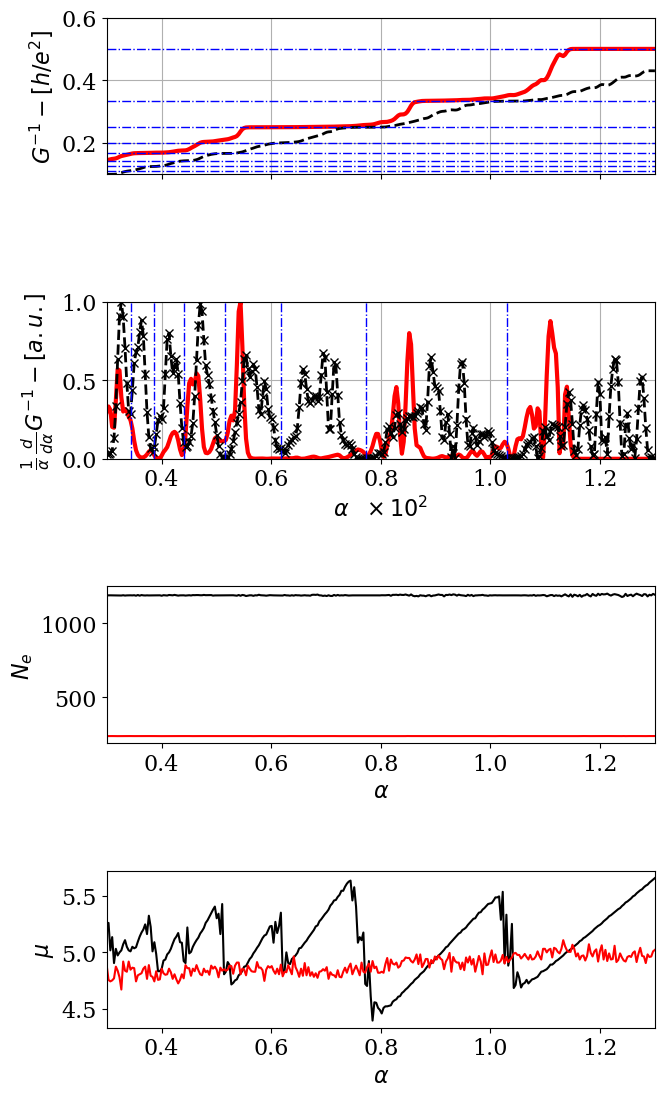

In [6]:
G0_g = gaussian_filter(G0, sigma=1.5)
GIMG_g = gaussian_filter(GIMG, sigma=1.5)
#G0_g = G0
#GIMG_g = GIMG

dG0_dalpha = np.gradient(1/G0_g, arr_alpha)
dGIMG_dalpha = np.gradient(1/GIMG_g, arr_alpha)

RIMG = 1/GIMG_g
R0 = 1/G0_g

arr_alpha_norm = arr_alpha*1e2
x0 = np.amin(arr_alpha_norm)
x1 = np.amax(arr_alpha_norm)

# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 8))
# First subplot
ax1.plot( arr_alpha_norm, RIMG, color='red', linestyle='-', linewidth=3)
ax1.plot( arr_alpha_norm, R0, color='black', linestyle='--', linewidth=2)
#for nnu in range(10):
    #ax1.axvline(  1.05*Nelect_0/ ((1+nnu)*(W-1)*(L-1)) , color='black', linewidth=2)  
    #ax1.axvline(  Nelect_img/ ((1+nnu)*(W-1)*(L-1)) , color='red', linewidth=2)
for mm in range(1,10):
      ax1.axhline(  1/mm , linewidth=1, color='blue', linestyle='-.')

der_img = np.abs(dGIMG_dalpha)/arr_alpha
der_0 = np.abs(dG0_dalpha)/arr_alpha

ax2.plot( arr_alpha_norm, der_img/np.amax(der_img), color='red', linestyle='-', linewidth=3)
ax2.plot( arr_alpha_norm,der_0/np.amax(der_0), color='black', marker='x', linestyle='--', linewidth=2)
aeff = 4
for mm in range(1,10):
      ax2.axvline(  Nelect_0/(mm*(W-aeff)*(L-aeff))*1e2 , linewidth=1, color='blue', linestyle='-.')

ax3.plot(arr_alpha_norm, arr_fil0*arr_alpha*(W-1)*(L-1), color='black')
ax3.plot(arr_alpha_norm, arr_filimg*arr_alpha*(W-1)*(L-1), color='red')


ax4.plot(arr_alpha_norm, arr_E0/omB0, color='black')
ax4.plot(arr_alpha_norm, arr_Eimg/omB0, color='red')

ax1.set_ylim((.1, .6))
ax1.set_xlim( (x0, x1) )
ax2.set_ylim((0, 1.))  
ax2.set_xlim( (x0, x1) )
ax3.set_xlim( (x0, x1) )
ax4.set_xlim( (x0, x1) )

#ax1.set_xlabel(r"$\alpha$", fontdict=font)
ax1.set_xticklabels([])

ax1.set_ylabel(r"$G^{-1} - [h/e^2]$", fontdict=font)

ax2.set_xlabel(r"$\alpha~~\times 10^{2}$", fontdict=font)
ax2.set_ylabel(r"$\frac{1}{\alpha} \, \frac{d}{d\alpha}G^{-1} - [a.u.]$", fontdict=font)

ax3.set_xlabel(r"$\alpha$", fontdict=font)
ax3.set_ylabel(r"$N_e$", fontdict=font)

ax4.set_xlabel(r"$\alpha$", fontdict=font)
ax4.set_ylabel(r"$\mu$", fontdict=font)

#ax2.set_yscale('log')  # Set log scale on y-axis
ax1.grid()
ax2.grid()
plt.tight_layout()
plt.gcf().set_size_inches(170 / 25.4, 300 / 25.4)

plt.show()

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_3174/341402839.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


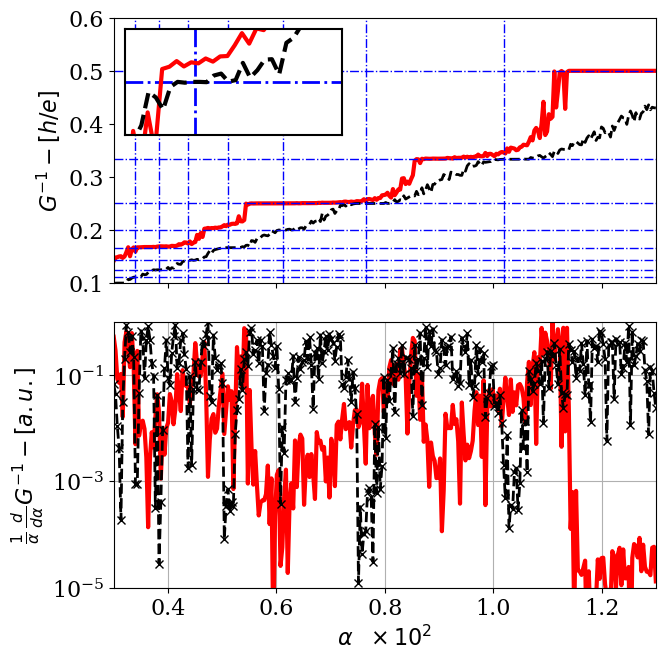

In [31]:
G0_g = gaussian_filter(G0, sigma=.15)
GIMG_g = gaussian_filter(GIMG, sigma=.15)
#G0_g = G0
#GIMG_g = GIMG

dG0_dalpha = np.gradient(1/G0_g, arr_alpha)
dGIMG_dalpha = np.gradient(1/GIMG_g, arr_alpha)

RIMG = 1/GIMG_g
R0 = 1/G0_g

arr_alpha_norm = arr_alpha*1e2
x0 = np.amin(arr_alpha_norm)
x1 = np.amax(arr_alpha_norm)

# Font configuration
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
# Apply the font globally
plt.rcParams['font.family'] = font['family']
plt.rcParams['font.size'] = font['size']
plt.rcParams['axes.labelsize'] = font['size']
plt.rcParams['xtick.labelsize'] = font['size']
plt.rcParams['ytick.labelsize'] = font['size']

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))


shift_a = .13

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Create inset axes inside ax1, in the bottom right
axins = inset_axes(ax1, width="40%", height="40%", loc='upper left', borderpad=.5)

# Set white background and black border
axins.set_facecolor('white')
for spine in axins.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Plot on the inset
aeff = 3
axins.axhline(1/5, linewidth=2, color='blue', linestyle='-.')
axins.axvline(  Nelect_0/(5*(W-aeff)*(L-aeff))*1e2 , linewidth=2, color='blue', linestyle='-.')
axins.plot(arr_alpha_norm + shift_a, RIMG, color='red', linestyle='-', linewidth=3)
axins.plot(arr_alpha_norm, R0, color='black', linestyle='--', linewidth=3)

# Set inset limits
axins.set_xlim(.58, .68)
axins.set_ylim(.19, .21)

# Optional: remove tick labels for a cleaner look
axins.set_xticks([])
axins.set_yticks([])


# First subplot
ax1.plot( arr_alpha_norm, RIMG, color='red', linestyle='-', linewidth=3)
ax1.plot( arr_alpha_norm, R0, color='black', linestyle='--', linewidth=2)
#for nnu in range(10):
    #ax1.axvline(  1.05*Nelect_0/ ((1+nnu)*(W-1)*(L-1)) , color='black', linewidth=2)  
    #ax1.axvline(  Nelect_img/ ((1+nnu)*(W-1)*(L-1)) , color='red', linewidth=2)
for mm in range(1,10):
    ax1.axhline(  1/mm , linewidth=1, color='blue', linestyle='-.')

der_img = np.abs(dGIMG_dalpha)/arr_alpha
der_0 = np.abs(dG0_dalpha)/arr_alpha

ax2.plot( arr_alpha_norm, der_img/np.amax(der_img), color='red', linestyle='-', linewidth=3)
ax2.plot( arr_alpha_norm,der_0/np.amax(der_0), color='black', marker='x', linestyle='--', linewidth=2)
aeff = 3
for mm in range(1,10):
    ax1.axvline(  Nelect_0/(mm*(W-aeff)*(L-aeff))*1e2 , linewidth=1, color='blue', linestyle='-.')


ax1.set_ylim((.1, .6))
ax1.set_xlim( (x0, x1) )
ax2.set_ylim((1e-5, 1.))  
ax2.set_xlim( (x0, x1) )


#ax1.set_xlabel(r"$\alpha$", fontdict=font)
ax1.set_xticklabels([])

ax1.set_ylabel(r"$G^{-1} - [h/e]$", fontdict=font)

ax2.set_xlabel(r"$\alpha~~\times 10^{2}$", fontdict=font)
ax2.set_ylabel(r"$\frac{1}{\alpha} \, \frac{d}{d\alpha}G^{-1} - [a.u.]$", fontdict=font)


ax2.set_yscale('log')  # Set log scale on y-axis
#ax1.grid()
ax2.grid()
plt.tight_layout()
plt.gcf().set_size_inches(170 / 25.4, 170 / 25.4)

#plt.savefig("fig4_secondpanel.pdf")

plt.show()

6.169099477382352


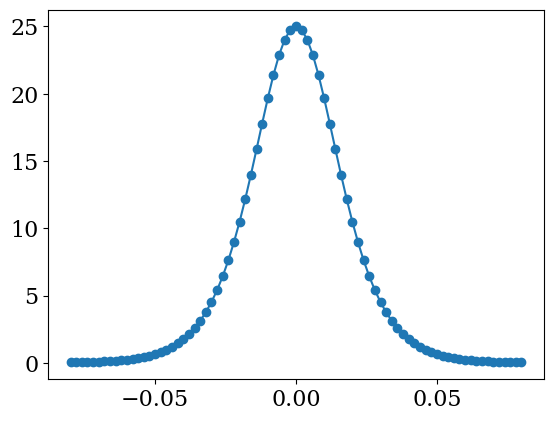

In [41]:
Tf = 0.01
arrE = np.linspace(-8*Tf,8*Tf,81)
arrF = np.exp(arrE / Tf) / (np.exp(arrE / Tf) + 1.0) ** 2.0 / Tf
plt.plot(arrE, arrF, marker='o')
print(np.sum(arrF)/81)